# Questão 1 - Mensagens

Q01 from First assignment
Class Deep Learning
UFPB

Mar, 30 2018.

Rafael Magalhães
GitHub @rafaelmm


"""
IMPORTANT THINGS HERE

The numbers of perceptrons must be the same as the dimension of output
So, it the target answer is a 3 positions vector, the number of perceptrons
must be also 3, to make compatible calculations and convergence
"""


In [1]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#-----------------------------------
 Dataset Generator
#-----------------------------------

In [2]:
def dataset_generator(n_tra, n_val=0, n_tes=0):
    """
    Generates a dataset that represents the ternary message system.

    @params:
    n_tra - the number of training examples to be generated
    n_val - the number of validation examples in dataset
    n_tes - the number of test examples in dataset

    returns a tuple of NumPy arrays in the format of
    (training inputs, training targets, validation input, ...
    validation target, test input, test targets)
    """
    total = n_tra + n_val + n_tes

    # Each example needs to be a randomly vector of three positions
    # with binary (0,1) number. Also, it has additive noise
    # of radialy 0.1 decimals. The target needs to be a eigth position
    # one hot encoded vector with binary (-1 , 1) without noise.
    allset_in = np.random.randint(2, size=(total, 3))
    allset_noise = np.random.rand(total, 3) * 0.2 - 0.1
    allset_target = np.full((total, 8), -1)

    # allset_target adjust bin to one_hot_binary
    for x in range(total):
        # obtaining the position bin to dec
        p = int(''.join(str(y) for y in allset_in[x]), 2)
        allset_target[x, p] = 1

    # adding noise to dataset
    allset_in = np.add(allset_in, allset_noise)

    # scattering the dataset
    tra_in = allset_in[0:n_tra, :]
    tra_out =  allset_target[0:n_tra, :]
    val_in = allset_in[n_tra:(n_tra+n_val), :]
    val_out = allset_target[n_tra:(n_tra+n_val), :]
    tes_in = allset_in[(total-n_tes):total, :]
    tes_out = allset_target[(total-n_tes):total, :]

    return (tra_in, tra_out, val_in, val_out, tes_in, tes_out)


#-----------------------------------
 Dataset Plot Viewer
#-----------------------------------

In [3]:
def plot_data(ti, vi, tei):
    """
    Function to show in a 3D scatter plot the distribution of the dataset
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(ti[:,0], ti[:,1], ti[:,2], c='b', marker='o')
    ax.scatter(vi[:,0], vi[:,1], vi[:,2], c='r', marker='^')
    ax.scatter(tei[:,0], tei[:,1], tei[:,2], c='g', marker='x')
    
    # title and axis labels
    ax.set_title('Dataset distribution')
    ax.set_xlabel('Coordenada 1 [x, , ]')
    ax.set_ylabel('Coordenada 2 [ ,y, ]')
    ax.set_zlabel('Coordenada 3 [ , ,z]')

    plt.show()


#-----------------------------------
 Plot Error Viewer
#-----------------------------------

In [4]:
def plot_error(error_vector):
    """
    Function to show the progress of the error vector
    """
    fig2 = plt.figure()
    
    plt.plot(range(len(error_vector)), error_vector)
    plt.title('Error value evolution')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Error value')
    plt.show()


#-----------------------------------
 Weights Structure Creator
#-----------------------------------

In [5]:
def weights_init(num_inputs, num_perceptrons=1):
    """
    Function that initialize the weights and the bias randomly using the numpy
    library.
    @Param: w, b - weights and bias values
    """

    w = np.random.random(size=(num_perceptrons, num_inputs + 1)) - 0.5
    b = 1
    # b = np.ones((num_perceptrons,1))
    return w, b


#-----------------------------------
 Activation Functions
#-----------------------------------

In [6]:
def activation_func(func_type, z):
    """
    Implements the different kind of activation functions including:
        sigm - sigmoidal
        tanh - hyperbolic tangent
        relu - Rectfied
        step - Heavside (binary step 0 or 1)
    """

    if func_type == 'sigm':
        return (1 / (1 + np.exp(-z)))

    if func_type == 'tanh':
        return (np.tanh(z))

    if func_type == 'relu':
        return np.max(np.array([0, z]))

    if func_type == 'step':
        return (1 if z > 0 else 0)



#-----------------------------------
 Forward Step of Neural Net
#-----------------------------------

In [7]:
def forward(w, b, X, func):
    """
    The forward pathway of the neuralnet, it calculates the result of the
    structure considering the X input. Its like a inner product, dot product.
    """
    n_perceptron = np.shape(w)[0]
    
    Z = np.zeros((n_perceptron, 1))
    out = np.zeros((n_perceptron, 1))
    
    for i in range(n_perceptron):
        Z[i] = np.dot(X, w[i,1:]) + w[i,0]*b
        out[i] = activation_func(func, Z[i])
        
    return out


#-----------------------------------
 Predict Limiar Output
#-----------------------------------

In [8]:
def predict(output):
    """
    It's just to round prediction of the perceptron to making
    results more conforming with the real target value
    """
    y_pred = [1 if x >= 0 else -1 for x in output]
    
    return y_pred


#-----------------------------------
 Training Function
#-----------------------------------

In [13]:
def training_perceptron(w, b, data_in, target, num_epochs, learn_rate, gamma):
    """
    This function execute the algorithm of weights adjustes
    following the steps of measure the error and changing the
    w structure
    @param:
        w - weights structure
        data_in - training dataset
        target - training targets of dataset
        num_epochs - the total overall loopings to adjuste the w
        learn_rate - the coefficient that ponderate the changes in w
        gamma - a specified value for maximum error acepted in training
    """
    
    num_examples = np.shape(data_in)[0]
    err_vec = np.empty((num_epochs, 1))
    
    for ep in range(num_epochs):

        ex_error_track = np.zeros((num_examples,8))
        ep_error = np.zeros((8,1))
        
        for ex in range(num_examples):
            y_pred = forward(w, b, data_in[ex], 'tanh')
            ex_error = target[ex] - np.transpose(y_pred)
            parcel = np.transpose(ex_error) * data_in[ex]
            parcel2 = np.append(np.transpose(np.array(ex_error)), parcel, axis=1)
            w = np.add(w, parcel2*learn_rate)
            ex_error_track[ex] = ex_error
        
        ep_error = np.sum(np.abs(ex_error_track))
        ep_error /= num_examples*8
        err_vec[ep] = ep_error
   
    return (w, ep, err_vec)


# The Main Section of Solution

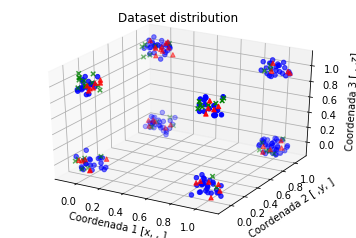

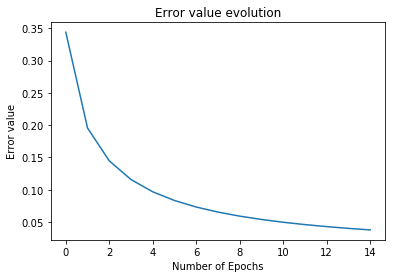

Matriz de Confusão:
[[7 0]
 [0 1]]
F1 Score:
             precision    recall  f1-score   support

         -1       1.00      1.00      1.00         7
          1       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00         8



In [19]:
# Generating the dataset
(ti, to, vi, vo, tei, teo) = dataset_generator(200, 50, 50)

# Ploting data to graphicaly understanding
plot_data(ti, vi, tei)

# creating the weightings structure
in_dimension = np.shape(ti)[1]
out_dimension = np.shape(to)[1]
(w, b) = weights_init(in_dimension, out_dimension)

# testing the forward pass
#predict(forward(w, b, ti[0], 'tanh'))

(w_up, num_ep, error_vect) = training_perceptron(w, b, ti, to, 15, 0.1, 0.1)

plot_error(error_vect)

y_pred3 = np.array(list(predict(forward(w_up, b, vi[x], 'tanh')) for x in range(50)))

print('Matriz de Confusão:')
print(confusion_matrix(vo[0], y_pred3[0]))

print('F1 Score:')
print(classification_report(vo[0], y_pred3[0]))